# Team 34: Members of the group and their tasks
Aayushi Barve - Global navigation and motion control<br>
Paul Bourgois - Local navigation<br>
Alexandros Dellios - Kalman filter<br>
Mathys Gamper - Vision<br>


# Vision
The setup for this project was:

- A green background for the map
- Some black obstacles
- A red goal
- An ArUco marker on the thymio

The map, obstacles and goal will be detected using threshold while the thymio position will be computed from the ArUco position on its back.

Most of the vision part of this project was made using the OpenCV library for python: https://opencv.org/.

The cells below will be explained while working on an example image, but the same logic apply while the code is running live with the camera.

In [1]:
# Necessary library and import for this project and this report
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt

import config
import vision

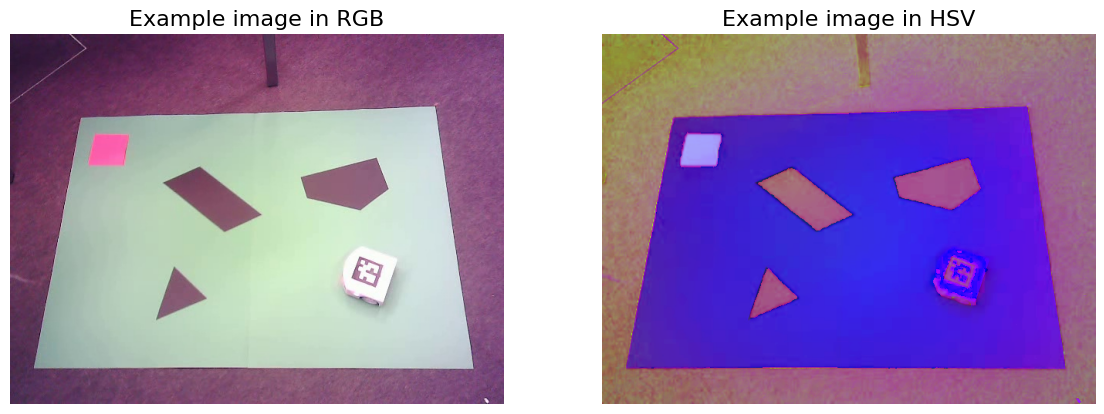

In [2]:
# Load and plot example image
img_bgr = cv2.imread("VisionSetup.jpg")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Example image in RGB", fontsize=16)
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Example image in HSV", fontsize=16)
plt.imshow(img_hsv)
plt.axis('off')

plt.show()

#### Functions used below for plot ###

Heavily inspired from the course EE-451 "Image analysis and pattern recognition"

In [3]:
def extract_channels(img):
    data_0 = img[:, :, 0]
    data_1 = img[:, :, 1]
    data_2 = img[:, :, 2]
    
    return data_0, data_1, data_2

# Plot color space distribution 
def plot_colors_histo_rgb(
    img: np.ndarray,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    channels = extract_channels(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()

# Plot color space distribution 
def plot_colors_histo_hsv(
    img: np.ndarray,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    channels = extract_channels(img=hsv_img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()

## Map detection ##

We will detect the map from the image and flatten it accordingly, this will be done in differents steps:

1. Detect the green part of the images
2. Detect the corner of the green rectangle
3. Flatten the images to the corner of the map

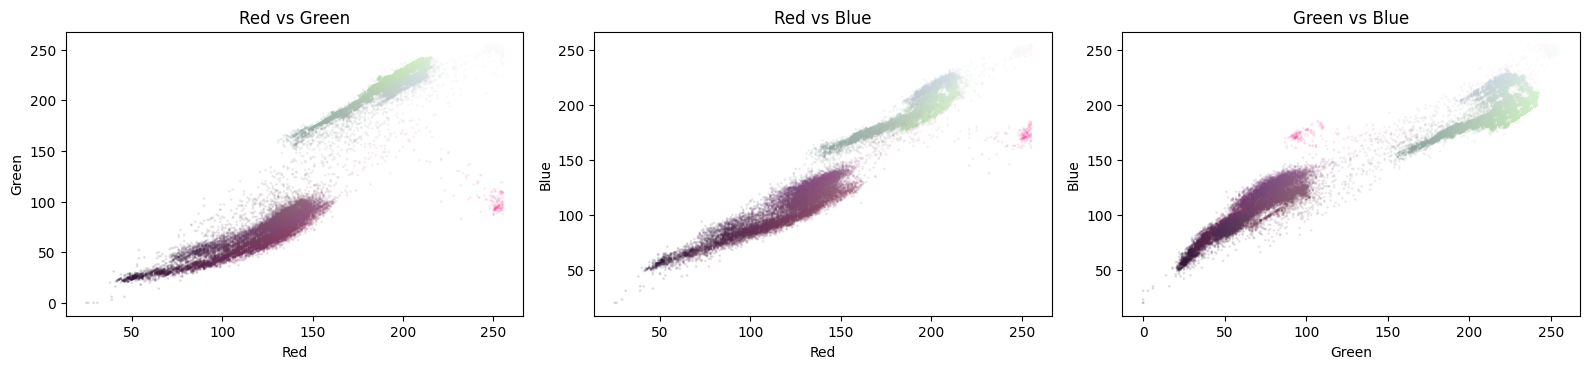

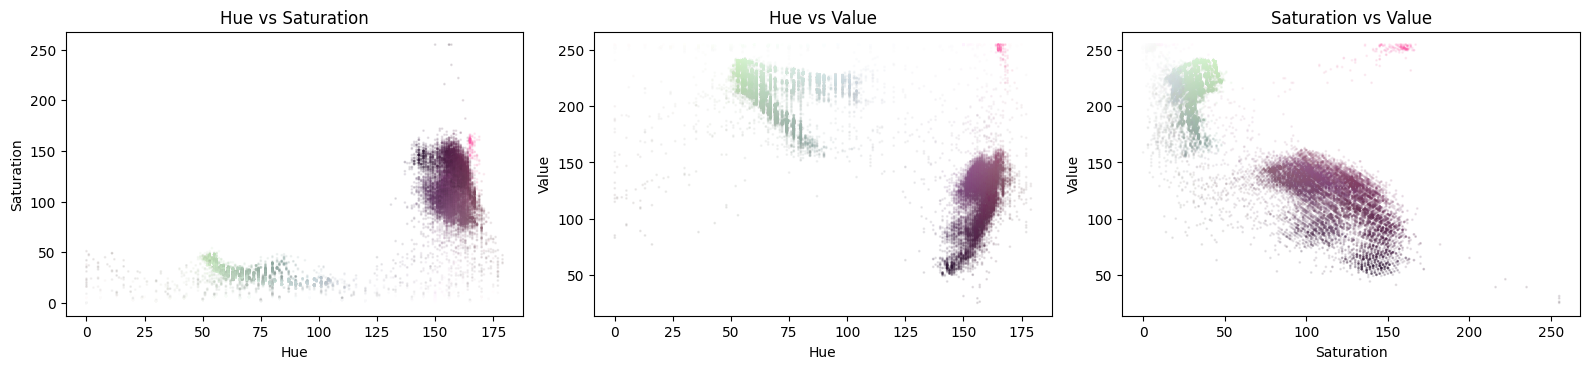

In [4]:
plot_colors_histo_rgb(
    img = img_rgb,
    labels = ["Red", "Green", "Blue"],
)

plot_colors_histo_hsv(
    img = img_rgb,
    labels = ["Hue", "Saturation", "Value"],
)


From the graph above, the threshold applied to separate the green pixels from the rest can be easily set and finetuned based on the light conditions.

- The function detect_mask(img, th) in vision.py compares the image with the threshold values and return a mask of where the pixel are within the ranges.
- The holes in the mask can then be filled using a function from the scipy library: https://scipy.org/

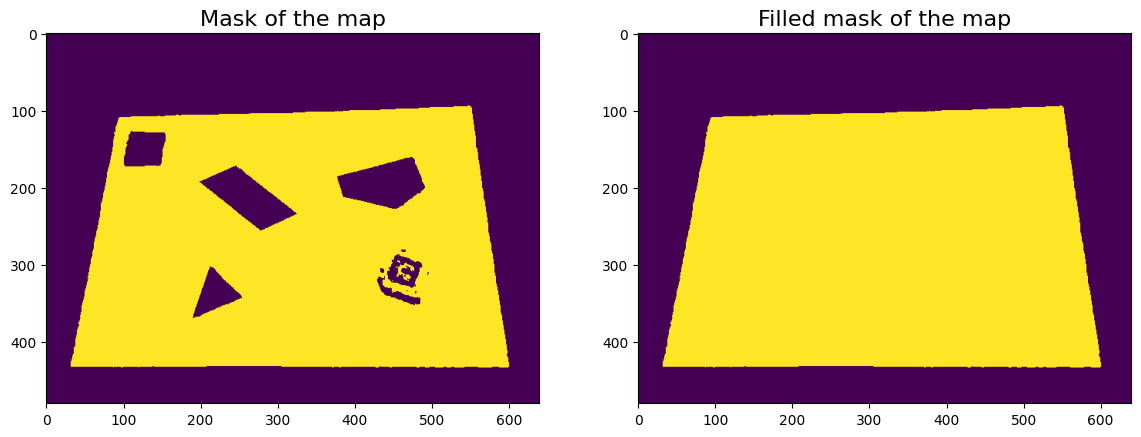

In [5]:
#threshold used to detect the green pixels
map_th = {
    "max_r": 255, "min_r": 100, "max_g": 255, "min_g": 130, "max_b": 255, "min_b": 100,
    "max_h": 125, "min_h": 0, "max_s": 80, "min_s": 0, "max_v": 255, "min_v": 100,
}

map_mask = vision.detect_mask(img_bgr, map_th)

mask_filled = scipy.ndimage.binary_fill_holes(map_mask).astype(np.uint8) * 255

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Mask of the map", fontsize=16)
plt.imshow(map_mask)

plt.subplot(1, 2, 2)
plt.title("Filled mask of the map", fontsize=16)
plt.imshow(mask_filled)

plt.show()

The function get_rect_corner(mask) from vision.py get then called to detect the four corner of the map. The function does mutliple things:

- It verify That the mask contains a contour
- It approximate this contour to get smoother edges and verify that it has 4 corners
- Rearrange the order of the point so that it follows a continous order

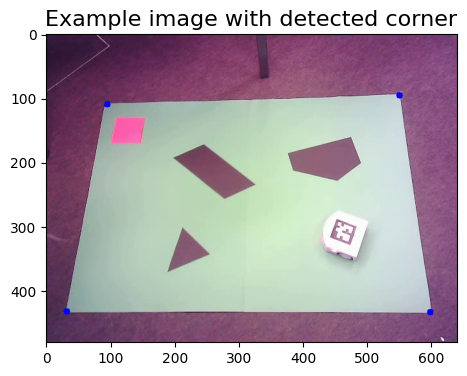

In [6]:
rect, _ = vision.get_rect_corner(map_mask)

img_with_corner = img_rgb.copy()

for corner in rect:
    cv2.circle(img_with_corner, np.int32(corner), config.radius, config.red, config.thickness)

plt.figure(figsize=(10, 4))
plt.title("Example image with detected corner", fontsize=16)
plt.imshow(img_with_corner)

These corners can then be used to compute the height and width of the map and also the perspective transformation matrix M that will deform the images to get a flattened map with the function warpPerspective(frame, M, (width, height)) from the OpenCV library.

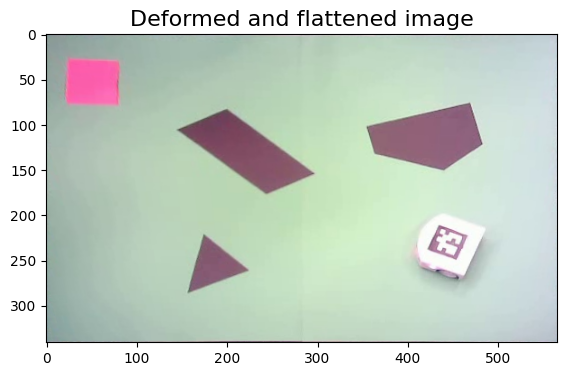

In [7]:
# Implemented logic applied to flatten the map

width_top = np.linalg.norm(rect[0] - rect[1])
width_bottom = np.linalg.norm(rect[3] - rect[2])
width = int(max(width_top, width_bottom))

height_left = np.linalg.norm(rect[0] - rect[3])
height_right = np.linalg.norm(rect[1] - rect[2])
height = int(max(height_left, height_right))

dst = np.array([
    [0, 0],
    [width-1, 0],
    [width-1, height-1],
    [0, height-1]
], dtype=np.float32)

M = cv2.getPerspectiveTransform(rect, dst)

warped_img = cv2.warpPerspective(img_rgb, M, (width, height))
warped_img_bgr = cv2.cvtColor(warped_img, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(10, 4))
plt.title("Deformed and flattened image", fontsize=16)
plt.imshow(warped_img)


The frame are in pixel value but the robot get its position in centimeter, a function that would then compute the height and width of a pixel based on the size of the map was thus created to translate the dimensions.

In [8]:
pixel_size = (config.map_width/len(warped_img[0]), config.map_height/len(warped_img))

print("pixel size in cm: ", pixel_size)

pixel size in cm:  (0.17667844522968199, 0.20527859237536658)


## Obstacles detection ##

The same logic than for the map is also applied to detect the obstacles with different threshold.

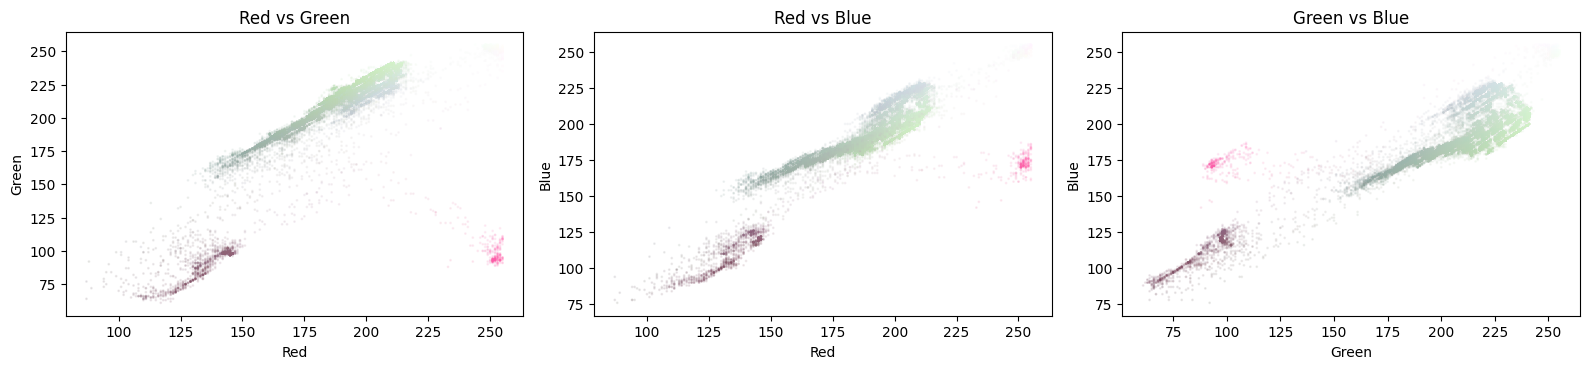

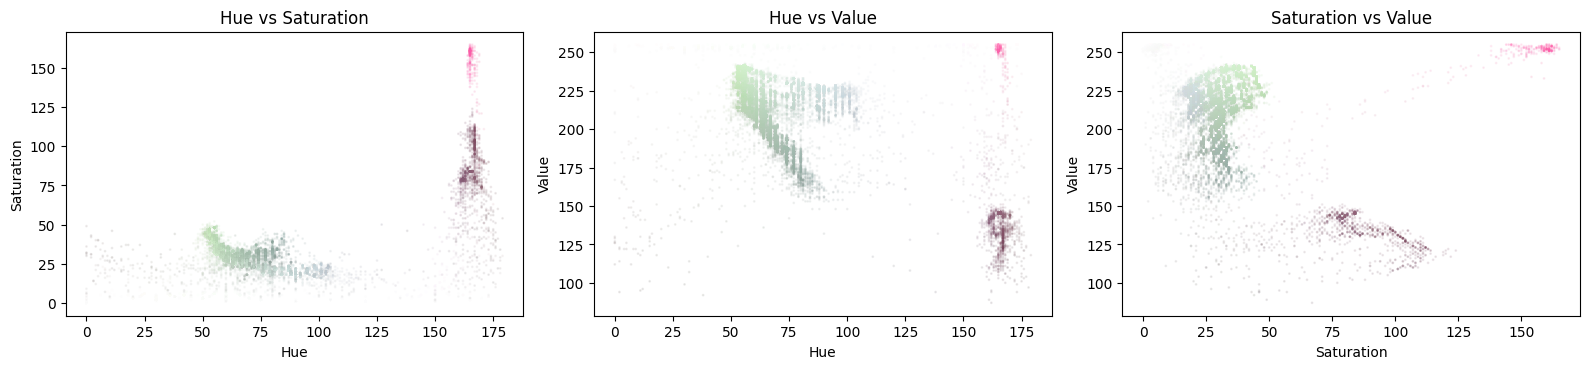

In [9]:
plot_colors_histo_rgb(
    img = warped_img,
    labels = ["Red", "Green", "Blue"],
)

plot_colors_histo_hsv(
    img = warped_img,
    labels = ["Hue", "Saturation", "Value"],
)

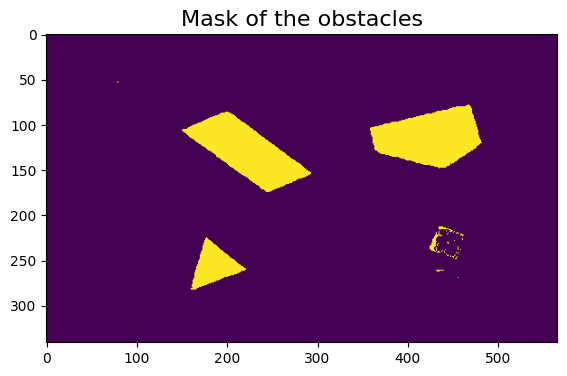

In [10]:
obstacle_th = {
    "max_r": 180, "min_r": 1, "max_g": 130, "min_g": 1, "max_b": 160, "min_b": 1,
    "max_h": 179, "min_h": 100, "max_s": 150, "min_s": 50, "max_v": 200, "min_v": 50,
}

obstacle_mask = vision.detect_mask(warped_img_bgr, obstacle_th)

plt.figure(figsize=(14, 4))
plt.title("Mask of the obstacles", fontsize=16)
plt.imshow(obstacle_mask)


The corner are then computed from the different shape and an offset is added to take into account the size of the thymio.

The offset is added by computing the bissection between the two edges of each corner and multiplying it by an length that is roughly equal to half the width of the thymio.

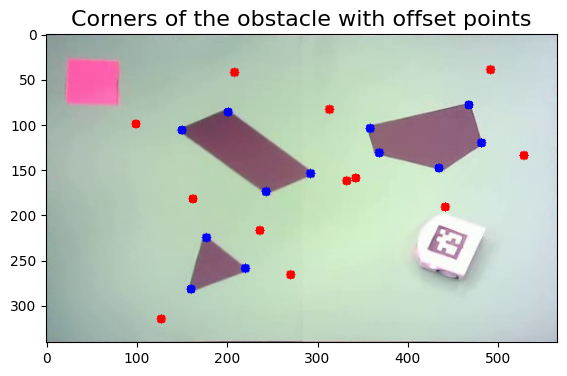

In [11]:
# Logic to compute the corner with the offset to take into account the size of the Thymio.

warped_img_with_corner = warped_img.copy()

contours, _ = cv2.findContours(obstacle_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
offset=config.robot_width/2
obstacles = []
all_corners = []
for cnt in contours:
    if cv2.contourArea(cnt) < config.min_obstacle_area:
        continue

    peri = cv2.arcLength(cnt, True)
    eps = config.epsilon_ratio * peri

    approx = cv2.approxPolyDP(cnt, eps, True)
    pts = approx.reshape(-1, 2).astype(np.float32)
    pts = pts * pixel_size

    offset_pts = []
    corners = []
    for i in range(len(pts)):
        p_prev = pts[(i - 1) % len(pts)]
        p_curr = pts[i]
        p_next = pts[(i + 1) % len(pts)]

        v1 = p_prev - p_curr
        v2 = p_next - p_curr
        v1 /= np.linalg.norm(v1) + 1e-6
        v2 /= np.linalg.norm(v2) + 1e-6

        bisector = v1 + v2
        norm = np.linalg.norm(bisector)
        if norm < 1e-6:
            bisector = v1
        else:
            bisector /= norm

        new_pt = p_curr - bisector * offset
        corners.append(pts[i])
        offset_pts.append(new_pt)

        cv2.circle(warped_img_with_corner, np.int32(pts[i]/pixel_size), config.radius, config.red, config.thickness)
        cv2.circle(warped_img_with_corner, np.int32(new_pt/pixel_size), config.radius, config.blue, config.thickness)

    all_corners.append(np.array(corners, dtype=np.float32))
    obstacles.append(np.array(offset_pts, dtype=np.float32))


plt.figure(figsize=(14, 4))
plt.title("Corners of the obstacle with offset points", fontsize=16)
plt.imshow(warped_img_with_corner)



### Output for local and global navigation ###

The requested output for local and global navigation are computed using the function format_obstacles(obstacle_points) and vision.mask_from_points(obstacle_array) from vision.py

- The output for local is a mask that say if the robot is inside the zone of an obstacle or not
- The ouptut for global is an array of shape (x, y, idx) with idx being the id of the obstacle

The coordinates system is in centimeter and the orientation of the mask is swapped on the vertical axis because the navigation use a coordinate system with the bottom-left corner as origin while the vision origin is on the top-left corner.

Array for global navigation:
 [[47.75139236 15.38105011  0.        ]
 [28.71369362 32.44102478  0.        ]
 [22.46008873  5.23671722  0.        ]
 [17.58776093 49.48163605  1.        ]
 [41.7598877  25.35829163  1.        ]
 [60.50691223 37.16619492  1.        ]
 [36.80140686 61.25325012  1.        ]
 [93.4581604  42.33996582  2.        ]
 [86.90654755 61.84066391  2.        ]
 [55.33512497 52.93363953  2.        ]
 [58.71059036 36.68816376  2.        ]
 [78.08863068 30.72993469  2.        ]]


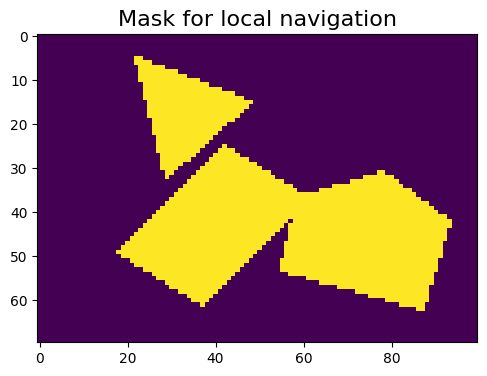

In [12]:
obstacle_array = vision.format_obstacles(obstacles) # output for global nav
obstacle_mask = vision.mask_from_points(obstacle_array) # output for local nav

print("Array for global navigation:\n", obstacle_array)

plt.figure(figsize=(14, 4))
plt.title("Mask for local navigation", fontsize=16)
plt.imshow(obstacle_mask)


## Goal detection ##

The goal is also detected using threshold values.

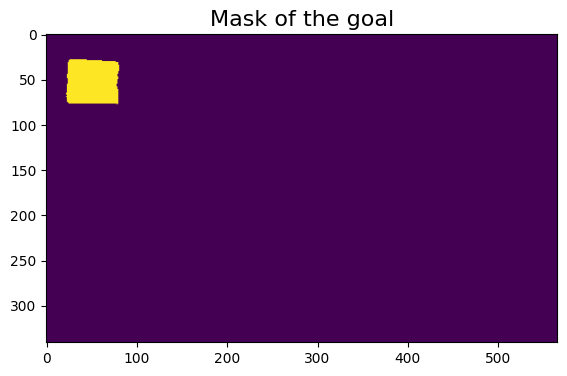

In [13]:
goal_th = {
    "max_r": 255, "min_r": 200, "max_g": 130, "min_g": 0, "max_b": 220, "min_b": 130,
    "max_h": 180, "min_h": 140, "max_s": 255, "min_s": 0, "max_v": 255, "min_v": 220,
}

goal_mask = vision.detect_mask(warped_img_bgr, goal_th)

plt.figure(figsize=(14, 4))
plt.title("Mask of the goal", fontsize=16)
plt.imshow(goal_mask)

The mask is then refined and the center of the red square is computed and defined as the goal position.

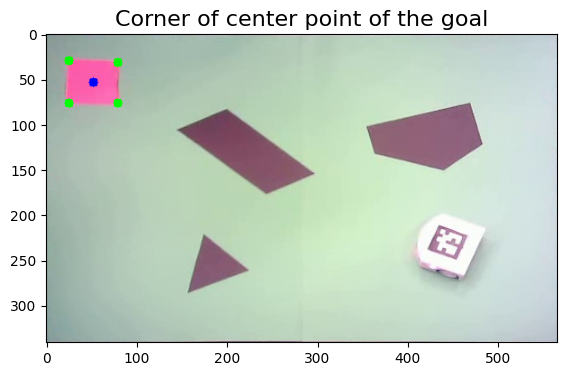

In [14]:
contours, _ = cv2.findContours(goal_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if not contours :
    exit()

cnt = max(contours, key=cv2.contourArea)

if cv2.contourArea(cnt) < config.min_goal_area:
    exit()

peri = cv2.arcLength(cnt, True)
epsilon = config.epsilon_ratio * peri
approx = cv2.approxPolyDP(cnt, epsilon, True)

if len(approx) != 4:
    exit()

corners_goal = approx.reshape(-1, 2).astype(np.float32)
center = corners_goal.mean(axis=0)

warped_img_with_goal = warped_img.copy()

for corner in corners_goal:     
    cv2.circle(warped_img_with_goal, np.int32(corner), config.radius, config.green, config.thickness)
cv2.circle(warped_img_with_goal, np.int32(center), config.radius, config.red, config.thickness)

plt.figure(figsize=(14, 4))
plt.title("Corner of center point of the goal", fontsize=16)
plt.imshow(warped_img_with_goal)


## Thymio detection ##

The Thymio is detected using ArUco marker with the help of OpenCV.

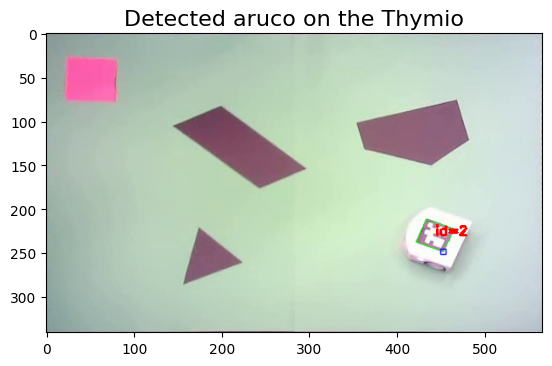

In [15]:
markerCorners = []
markerIds = []
detectorParams = cv2.aruco.DetectorParameters()

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_250)
detector = cv2.aruco.ArucoDetector(dictionary, detectorParams)
markerCorners, markerIds, _ = detector.detectMarkers(warped_img)

warped_img_ArUco = warped_img.copy()

cv2.aruco.drawDetectedMarkers(warped_img_ArUco, markerCorners, markerIds)
plt.title("Detected aruco on the Thymio", fontsize=16)
plt.imshow(warped_img_ArUco)

The center and the orientation of the Thymio is then computed from the 4 corners of the ArUco marker.

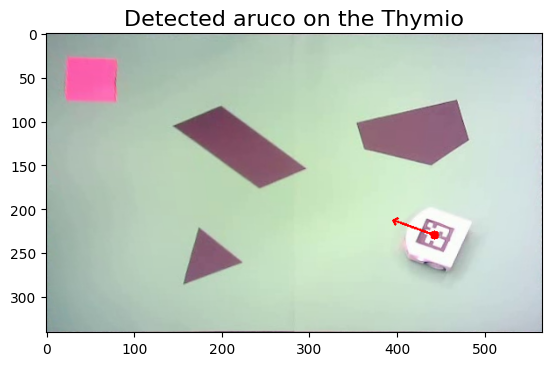

In [16]:
markerCorners_np = np.array(markerCorners)[0][0]
center = markerCorners_np.mean(axis=0)

v = markerCorners_np[1] - markerCorners_np[0]
v = v / np.linalg.norm(v)
angles = np.arctan2(v[1], v[0])

end_x = int(center[0] + config.arrow_length * np.cos(angles))
end_y = int(center[1] + config.arrow_length * np.sin(angles))
end_point = np.array((end_x, end_y))

warped_img_Thymio = warped_img.copy()

cv2.circle(warped_img_Thymio, np.int32(center), config.radius, config.blue, config.thickness)
cv2.arrowedLine(warped_img_Thymio,
    tuple(center.astype(int)),
    tuple(end_point.astype(int)),
    config.blue, config.thickness_line)

plt.title("Detected aruco on the Thymio", fontsize=16)
plt.imshow(warped_img_Thymio)

All of the above functions and algorithms are in implemented in the vision.py file. The map, obstacle and goal detection are done at the beginning of the program and the Thymio detection is done everytime the program goes through the while loop of the main file.

Two function grab_frame(cam) and retry_detection(name,func, cam, ...) where also implemented to make the code more robust, the idea was that before ending the code in case of undetected objects, the camera would check on multiple frames of different instances to see if the error was not due to variation between frames from the camera.

The functions implemented in vision.py might looks a bit different from what is shown above, while the logic is the same, some additional work where required to make the code more robust and compatible with the other part code.

# Global navigation
(Refer to the file aayushi_path_planning.py for the code)<br><br>
The corners of the obstacles (chosen as polygons), the start and the goal are extracted from the camera before the code is executed. While computing the path, instead of using the corners of the obstacles, the corners are offset by half the width of the Thymio to ensure that the Thymio at no point crosses over a global obstacle. These corners are then used to compute a visibility graph, where the corners of the obstacles, the start, and the goal are all vertices in a graph, and edges are any line connecting two vertices that does not pass through an obstacle. We then run Dijkstra algorithm on this graph (implemented by using the networkx https://networkx.org/documentation/stable/index.html# library that allows creation of graphs as well as implementing algorithms such a Dijkstra or A*). To preserve generality, while computing "valid" edges for the graph, we exclude any vertex that is out of bounds of the environment, or any vertex that lies within another obstacle (i.e. an overlap of obstacles). This is possible due to the offset in the vertex coordinates as mentioned above.<br><br>
To identify whether an edge intersects an obstacle, we try to find if this edge intersects any of the sides of the polygonal obstacle. If the edge we are looking at is AB and the side of the polygon is CD, the intersection point should be between A & B and between C& D. To identify this, we can check the sense of the vertices of the triangles constructed by ACD, BCD, CAB and DAB. ACD and BCD must have a sense opposite to each other (if one is clockwise the other must be anti-clockwise). The sme holds true for CAB and DAB. To find if a point lies within an obstacle, we count how many times a horizontal ray drawn from this point intersects with the edges of the obstacle. If it intersects an even number of times, it lies outside, else it within the obstacle. (if the point lies within, it would intersect the edge once while getting out of the obstacle, and if it lies outside, the ray would intersect the obstacle twice, once while getting in and once while getting out. Intersections may be more than 2 if the polygon is not convex, but the property still holds true.)<br><br>
Below is an example of the generated graph. Vertices 5 and 16 are excluded since they are out of bounds of the arena which has dimensions $100\times70$. Vertices 17 and 9 are not connected with any edges since they lie within other obstacles. If there is such an overlap between two offset obstacles, the Thymio cannot pass through since the original obstacles are closer to each other than the width of the Thymio.

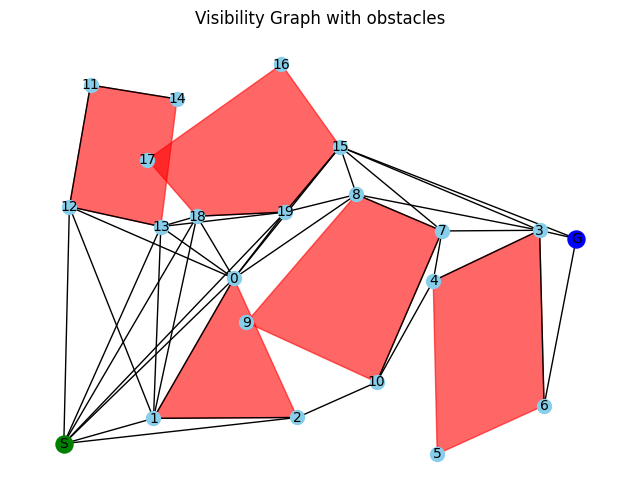

In [1]:
from aayushi_path_planning import construct_visibility_graph, plot_visibility_graph
import numpy as np
test = np.array([
    [33.2109642,  32.24681854,  0.        ],
    [17.5048542,   4.94321442,  0.        ],
    [45.56077957,  5.11058044,  0.        ],
    [92.86244202, 41.64347839,  1.        ],
    [72.09584808, 31.76406097,  1.        ],
    [72.87413025, -2.03749847,  1.        ],
    [93.7278595,   7.43364334,  1.        ],
    [73.82290649, 41.51294327,  2.        ],
    [57.1124382,  48.63783646,  2.        ],
    [35.64950943, 23.66869736,  2.        ],
    [61.07471848, 12.00874329,  2.        ],
    [ 5.21072817, 69.99662018,  3.        ],
    [ 1.09146953, 46.26845551,  3.        ],
    [18.93958855, 42.35803604,  3.        ],
    [22.09864044, 67.2664566,   3.        ],
    [53.9241066,  57.96432114,  4.        ],
    [42.47489929, 74.01866913,  4.        ],
    [16.33026314, 55.43266296,  4.        ],
    [25.9744339,  44.38056183,  4.        ],
    [43.21118927, 45.19765091,  4.        ],
])
G=construct_visibility_graph(test,np.array([0,0]),np.array([100,40]),(0,100,0,70))
plot_visibility_graph(G, test, np.array([0,0]), np.array([100,40]))

theta: 0.11170367735103635  end node: [45.56077957  5.11058044]  start node: [0 0]
theta: 0.4183900413621215  end node: [61.07471848 12.00874329]  start node: [45.56077957  5.11058044]
theta: 1.0619220759983703  end node: [72.09584808 31.76406097]  start node: [61.07471848 12.00874329]
theta: 0.4440487176685614  end node: [92.86244202 41.64347839]  start node: [72.09584808 31.76406097]
theta: -0.22631322072098922  end node: [100  40]  start node: [92.86244202 41.64347839]
['S', 2, 10, 4, 3, 'G']


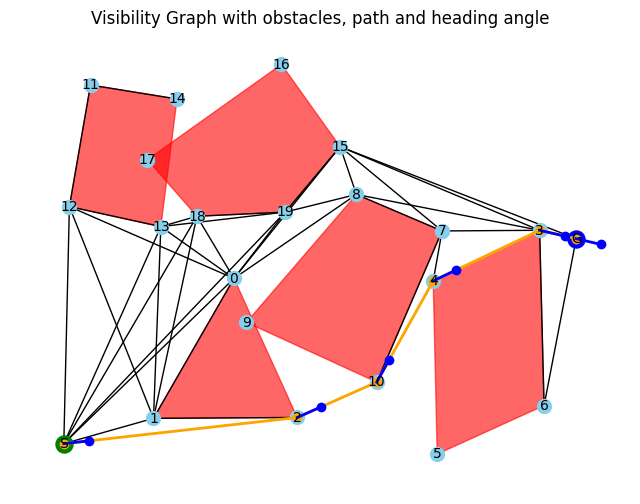

In [2]:
from aayushi_path_planning import plan_global_navigation, compute_orientations
path_idx=plan_global_navigation(G,'S','G')
path=compute_orientations(G,path_idx)
print(path_idx)
plot_visibility_graph(G, test, np.array([0,0]), np.array([100,40]),path)

The heading angles for the Thymio are computed such that the robot always rotates at the same vertex and aligns itself with the edge to be moved over (shown in blue in the figure above). At the goal, the heading angle remains the same as it was at the vertex before it reaches the goal

### Motion Control
Since we are controlling the robot using the wheel velocities, and we want to modify the position of the robot, we used a simple P controller. This was done in two phases. First, if the robot is currently at a vertex, the robot corrects its heading angle through pure rotation.<br>
$v=K_{p,\theta}(\theta _{desired}-\theta _{current})$<br>
$motor.right.target=v$, $motor.left.target=-v$ (A positive difference between desired and current angle requires anti-clockwise rotation, and so the right motor speed must also be positive, with the left being negative)<br><br>
After correcting the robot's orientation, the robot travels in a straight line along the edge of the graph.<br>
$v=K_{p,linear}\sqrt{(x_{desired}-x_{current})^2+(y_{desired}-y_{current})^2}$<br>
$motor.right.target=v$, $motor.left.target=v$<br><br>
In both cases ($\theta$ and $(x,y)$), the desired state is considered reached when the current state is within a tolerance $\epsilon$ of the desired state. Once both the heading and distance target for one edge in the path have been reached, the robot is given control inputs to head to the next waypoint in the path. In an ideal case, we would want the robot to first correct its orientation and then continu in a straight line to the next waypoint. However if the difference between the current and the desired heading angle is less than $\epsilon _{\theta}$, the robot may drift away from the desired straight line trajectory due to this small difference and due to the difference in the commanded velocity of the left and right wheels. So, we introduce a continuous angle correction that depends on the difference between the robot vector and the vector connecting the robot current position to the next waypoint position. At every loop, this angle is checked instead of simply the difference between the current and target angle.<br>
$v=K_{p,\theta}(\theta _{waypoint,robot}-\theta _{robot})$ - this expression is used for the continuous angle correction instead of the expresssion above.<br>
<br> Additionally, if for some reson the robot overshoots and its distance from the waypoint increases, to avoid a positive feedback we add a sign correction term equivalent to $sgn(dot(p_{robot},p_{robot,next waypoint}))$

In [19]:
def correct_orientation(target_or, current_or, Kp=30):
    angle=target_or-current_or
    if angle>3.14:
        angle-=2*3.14
    elif angle<-3.14:
        angle+=2*3.14
    speed=Kp*angle
    #if angle is positive, we want anticlockwise motion- left motor backwards, right motor forwards
    motor_left_target=-speed
    motor_right_target=speed
    return motor_left_target, motor_right_target, 0

def straight_line_motion(target,current_pos, Kp=10): #Epsilon 5 cm  for uncertainty as its approx half the width of the robot
    eps_dist=1 #tune this value for the P controller
    #assume orientation has already been corrected before this step
    dist=np.sqrt((target[0]-current_pos[0])**2+(target[1]-current_pos[1])**2)
    speed=Kp*dist
    thymio_heading_vector = np.array([np.cos(current_pos[2]), np.sin(current_pos[2])])
    displacement_vector = np.array([target[0]-current_pos[0], target[1]-current_pos[1]])
    sign_correction = np.sign(np.dot(thymio_heading_vector, displacement_vector))
    motor_left_target = sign_correction*speed
    motor_right_target = sign_correction*speed
    if abs(dist)<=eps_dist:
        #return 1 to signify current target node is reached - switch the target node to the next in the path
        #return 0 to signify we still need to move towards the same target node
        return motor_left_target, motor_right_target, 1
    return motor_left_target, motor_right_target, 0

def global_navigation(target,current_pos):
    #Decide whether to correct orientation or move in straight line
    angle = np.arctan2(target[1]-current_pos[1],target[0]-current_pos[0])
    angle_diff=angle-current_pos[2]
    dist=np.sqrt((target[0]-current_pos[0])**2+(target[1]-current_pos[1])**2)
    eps_theta=0.087 #5 degrees in radians
    eps_dist=1 #5 cm
    if abs(angle_diff)<=eps_theta and dist>=eps_dist:
        return straight_line_motion(target,current_pos)
    if dist>=eps_dist and abs(angle_diff)>=eps_theta:
        return correct_orientation(angle,current_pos[2])
    #Correct qngle first if both distance and angle error are significant
    if abs(angle_diff)>=eps_theta and dist<=eps_dist:
        return (0,0,1)
    else:
        return (0,0,1)

# Local navigation
The local navigation module uses the information from the Thymio's proximity sensors to detect and avoid obstacles that are dynamically introduced in the environment. The speed of the Thymio is modified such that it avoids the local obstacle, adjusts its heading to keep going roughly in the direction of the next waypoint, and also away from any global obstacles in its vicinity.<br>
1. Gradient due to next waypoint-<br>
$v_l = v_{nominal} - K \delta$ <br>
    $v_r = v_{nominal} + K \delta$, where $\delta$ is the angle between the current robot heading and the vector between the next waypoint and the robot
2. Adjustment for local obstacles based on proximity sensor readings-<br>
$v_l += (12 - distance[i]) K_{local}[i]$<br>
        $v_r += (12 - distance[i])K_{local}[4 - i]$<br>
As the distance to the obstacle decreases, the adjustment to the control commanded is more aggressive to avoid a collision. The distance threshold for taking any action for avoiding a local obstacle is 12 cm.
3. Adjustment for global obstacles in the vicinity of the robot-<br>
The global obstacles are also stored in the form of an occupancy grid for the robot to access in the case of appearance of a local obstacle. It is designed to repel the robot away from global obstacles in case the command to avoid the local obstacle sends it in the direction of a global obstacle. This part of the adjustment takes into consideration the global obstacles present within a radius of influence of the robot, and the strength of the repulsion is inversely proportional to the distance between the robot and the global obstacle.<br>
$i = max(0, (r_i - d/r_i))$, where d is the distance between the robot and the global obstacle occupied grid, and $i$ is the influence.<br>
$v_l -= K_{influence} * i$<br>
$v_r -= K_{influence} * i$<br>
The above adjustment is done for every grid square with a global obstacle within the radius of influence of the robot. <br>

After the above 3 components are added, the final control command is sent to the Thymio. The local navigation is triggered any time an obstacle is detected on any 1 of the proximity sensors within 12 cm of the robot, and we switch back to global when none of the sensors detect any obstacle within this distance.<br><br>
In the case that the local obstacle is placed directly on the next waypoint in the robot's path, the robot gets stuck in an infinite loop since it deviates to avoid the obstacle, and once its sensors detect nothing, it goes to global navigation and approaches the waypoint. Since the waypoint is below the local obstacle, it can never truly "reach" the waypoint. To address this case, we detect if the local obstacle lies on the next waypoint using the distances computed from the proximity sensor values, and if yes, we simply tell the robot to skip this waypoint and go to the next one in the path.

#### Replanning after local navigation-<br>
If the local obstacle is within a certain radius of the waypoints, that is it actively blocks the robot's path to this waypoint, the path is replanned to direct the robot to the next waypoint in the path while skipping the blocked waypoint. Additionally, if the robot is pushed too far away from the waypoint due to the local navigatin algorithm and obstacle placement, the previously planned path may no longer be optimal. So the path is replanned under this condition to allow the robot to still reach the goal.

In [20]:
def update_local_grid(local_grid,current_pos, prox_horizontal_i,i,path):
    # Calculate grid position (separate variables instead of tuple)
    pos_x=current_pos[0]
    pos_y=current_pos[1]
    grid_pos_x = pos_x * config.MAP_RES_X // config.map_width
    grid_pos_y = pos_y * config.MAP_RES_Y // config.map_height
    IS_OBSTACLE_DETECTED_IN_PATH = False

    # from 5 to 12 cm obstacle distance, on the angle of the sensor, on the basis frame reference,
    # we update the local grid to 1 to the first cell corresponding to the obstacle position
    # else we put 0 to the line, following the sensor direction
    sensor_angle = config.SENSOR_ANGLE[i] + current_pos[2]
    sensor_pos = config.SENSOR_POS[i] + np.array([pos_x, pos_y])
    if prox_horizontal_i > 0 :
        distance = (5739.9 - prox_horizontal_i) / 339.47
        if distance >= 5 and distance <= 12:
            obstacle_x = sensor_pos[0] + distance * np.cos(sensor_angle)
            obstacle_y = sensor_pos[1] + distance * np.sin(sensor_angle)
            for checkpoints in path:
                if np.sqrt((obstacle_x - checkpoints[0])**2 + (obstacle_y - checkpoints[1])**2) < config.RADIUS_AVOIDANCE:
                    IS_OBSTACLE_DETECTED_IN_PATH = True
            grid_obstacle_x = int(obstacle_x * config.MAP_RES_X // config.map_width)
            grid_obstacle_y = int(obstacle_y * config.MAP_RES_Y // config.map_height)
            if 0 <= grid_obstacle_x < config.MAP_RES_X and 0 <= grid_obstacle_y < config.MAP_RES_Y:
                # print(type(local_grid))
                local_grid[grid_obstacle_x, grid_obstacle_y] = 1
    else:
        # No obstacle detected in range, clear the line in the direction of the sensor between 0 and 15cm for each cell in between
        clear_points = np.array([[j * np.cos(sensor_angle) + sensor_pos[0],
                                  j * np.sin(sensor_angle) + sensor_pos[1]] for j in range(0, 16)])
        grid_clear_points = np.array(clear_points * np.array([config.MAP_RES_X / config.map_width, config.MAP_RES_Y / config.map_height]), dtype=int)
        for points in grid_clear_points:
            if not (0 <= points[0] < config.MAP_RES_X and 0 <= points[1] < config.MAP_RES_Y):
                grid_clear_points = grid_clear_points[grid_clear_points[:, 0] < config.MAP_RES_X]
                grid_clear_points = grid_clear_points[grid_clear_points[:, 1] < config.MAP_RES_Y]
                grid_clear_points = grid_clear_points[grid_clear_points[:, 0] >= 0]
                grid_clear_points = grid_clear_points[grid_clear_points[:, 1] >= 0]
                break
            else:
                # reset points around the sensors because of sensor noise
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        nx = points[0] + dx
                        ny = points[1] + dy
                        if 0 <= nx < config.MAP_RES_X and 0 <= ny < config.MAP_RES_Y:
                            local_grid[nx, ny] = 0
    return IS_OBSTACLE_DETECTED_IN_PATH, local_grid

def local_navigation(next_checkpoints, current_pos, distance, obstacle_map):
    # basic speed might need to be tune next to a checkpoint
    # maximum of 100 speed to avoid max speed toward checqkpoint if far away

    pos_x=current_pos[0]
    pos_y=current_pos[1]
    pos_theta=current_pos[2]
    diffDelta = np.arctan2(next_checkpoints[1] - pos_y, next_checkpoints[0] - pos_x) - pos_theta
    if diffDelta > 3.14:
        diffDelta -= 2 * 3.14
    elif diffDelta < -3.14:
        diffDelta += 2 * 3.14
    # speed based on nominal velocity and ground (gradient due to goal)
    spLeft = config.SPEED0 - config.SPEED_GAIN * diffDelta
    spRight = config.SPEED0 + config.SPEED_GAIN * diffDelta
    # print("spLeft before limit:", spLeft)
    # print("spRight before limit:", spRight)

    # We don't allow more than 100 speed for checkpoint approach and there's no max function
    spMax = np.max([abs(spLeft), abs(spRight)])

    if spMax > config.MAX_SPEED_CHECKPOINT_APPROACH or spRight > config.MAX_SPEED_CHECKPOINT_APPROACH:
        spLeft = spLeft * config.MAX_SPEED_CHECKPOINT_APPROACH // spMax
        spRight = spRight * config.MAX_SPEED_CHECKPOINT_APPROACH // spMax

    # adjustment for obstacles ("gradient" due to obstacles)
    # spLeft, spRight = 0,0
    for i in range(5):
        spLeft += (12 - distance[i]) * config.OBS_SPEED_GAIN[i]
        spRight += (12 - distance[i]) * config.OBS_SPEED_GAIN[4 - i]
    #     print("Distance sensor", i, ":", distance[i])
    #     print("spLeft intermediate for sensor", i, ":", spLeft)
    # print("spLeft after obstacle adjustment:", spLeft)
    # print("spRight after obstacle adjustment:", spRight)


    # Calculate grid position (separate variables instead of tuple)
    grid_pos_x = int(pos_x * config.MAP_RES_X // config.map_width)
    grid_pos_y = int(pos_y * config.MAP_RES_Y // config.map_height)

    # compute the positions of the obstacles that will have an influence on the robot with the config.RADIUS_INFLUENCE
    for i in range(-config.RADIUS_INFLUENCE, config.RADIUS_INFLUENCE + 1):
        for j in range(-config.RADIUS_INFLUENCE, config.RADIUS_INFLUENCE + 1):
            check_x = grid_pos_x + i
            check_y = grid_pos_y + j
            if 0 <= check_x < config.MAP_RES_X and 0 <= check_y < config.MAP_RES_Y:
                # Calculate distance squared (avoid sqrt and float division)
                dist_sq = i * i + j * j
                if dist_sq <= config.RADIUS_INFLUENCE * config.RADIUS_INFLUENCE:
                    if obstacle_map[check_x, check_y] == 1:
                        # sg = 1 if the obstacle is on the left side, -1 if on the right side
                        sg = 1 if (i * np.cos(pos_theta) + j * np.sin(pos_theta)) > 0 else -1
                        # Simplified influence calculation (avoid float division)
                        influence = max(0, (config.RADIUS_INFLUENCE - np.sqrt(dist_sq))/config.RADIUS_INFLUENCE)
                        spLeft += config.SPEED1 + sg * config.STRENGHT_INFLUENCE * influence
                        spRight += config.SPEED1 - sg * config.STRENGHT_INFLUENCE * influence

    # motor control
    motor_left_target = spLeft
    motor_right_target = spRight
    return motor_left_target, motor_right_target


# Filtering
(Refer to the file kalman_filter.py for the code)<br><br>
The model of the system using Euler discretization is as follows- the state vector comprises of $[x, y, \theta]^\top$, and the non-linear equations of motion given the left and right linear velocities of the wheels $v_l$ and $v_r$, and the wheel separation of the thymio $b$ are as given below <br>
$v_f=\frac{v_l+v_r}{2}$<br>
$\omega=\frac{v_r-v_l}{2b}$<br>
$x^+=x+v_f\cos\theta\Delta t$<br>
$y^+=y+v_f\sin\theta\Delta t$<br>
$\theta^+=\theta+\omega \Delta t$<br>
Here $\Delta t$ is the sampling interval. Due to the nonlinear dynamics, we implement the extended Kalman filter that uses the Jacobians of the state transition function for the covariance matrix updates. So we have-<br><br>
$x^+=f(x,u)+w$,     $y=Hx+v$,    $F=\frac{\partial{f}}{\partial{x}}|_{(x,u)}$,     $B=\frac{\partial{f}}{\partial{u}}|_{(x,u)}$ <br><br>
$F=\begin{bmatrix}
1 & 0 & -v_f\sin\theta\Delta t \\
0 & 1 & -v_f\cos\theta\Delta t \\
0 & 0 & 1
\end{bmatrix}$,
$B=\begin{bmatrix}
\frac{\cos\theta\Delta t}{2} & \frac{\cos\theta\Delta t}{2} \\
\frac{\sin\theta\Delta t}{2} & \frac{\sin\theta\Delta t}{2}  \\
\frac{-\Delta t}{2} & \frac{\Delta t}{2}
\end{bmatrix}$, $H= \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{bmatrix}$<br>
$H$ is the identity matrix since the camera is directly measuring the state of the system (subject to some noise $v$ corresponding to the camera properties)<br>
Notation- $P$ is the covariance matrix for the initial error estimate, $Q$ is the covariance matrix for the process noise and $R$ is the covariance matrix for the measurement noise. <br><br>
Prediction update:<br>
$x_{prior}=f(x,u)$<br>
$P_{prior}=FPF^T+Q$<br>
The usual prediction update uses the Jacobians $x_{prior}=Fx+Bu$ in the library, however if the estimation is too far off because of the linearization, the original non-linear model can be used for the prediction update. We simulated the filter for a test trajectory and observed a larger error in $\theta$, so we decided to use the non-linear model for the motion update.
Measurement update:<br>
$K=PH^T(R+HPH^T)^{-1}$<br>
$r=y-Hx$ (residual)<br>
$x_{post}=x_{prior}+Kr$<br>
$P_{post}=(I-KH)P_{prior}$<br><br>
However, the filterpy library uses $P_{post}=(I-KH)P_{prior}(I-KH)^T + KRK^T$ as it is more numerically stable.<br>
Estimation of uncertainty in states induced due to input uncertainty:<br>
$Q_{input}=B\Sigma _u B^T$, where $B=\frac{\partial{f}}{\partial{u}}|_{(x,u)}$ is the input Jacobian, and $\Sigma _u$ is the variance of the inputs. This is due to the propagation of uncertainty -<br>
$f(x,u+\delta u)\approx f(x,u)+B\delta u$<br>
$\mathrm{Cov}(\delta x)=\mathrm{Cov}(B \delta u)=B\mathrm{Cov}(\delta u)B^T=B\Sigma _u B^T$<br>
We choose $Q=Q_{input}+Q_{model}$, where $Q_{model}$ is tuned to account for unmodeled effects such as friction/slip etc that may cause uncertainty in the state.<br>
The matrix $R$ depends on the resolution of the camera since it signifies the uncertainty in the measurement of the state.<br><br>

In case of a robot kidnapping, (the condition checked is if the difference between successive camera measurements is more than 20 cm), the filter is initialized to only the camera measurement (begin with complete belief in the camera measurement, as the motion update is ureliable due to change in position). If the camera data is unavailable, the posterior update is simply changed to $x_{post}=x_{prior}$ and relies completely on the motion model using the wheel velocity inputs.

### Uncertainty measurement
1. $R$ - Camera noise<br>
We used the Aruco marker to take multiple measurements of the robot position for $x$, $y$ and $\theta$ and computed the covariance matrix for the difference between the camera measurement and the "true" value which was the position we placed te Aruco marker at using rulers to estimate the error in the camera measurements.
2. $\Sigma _u$ estimation- uncertainty between commanded input and realized input<br>
We commanded a set of speeds to the Thymio and sampled wheel velocity measurements at uniform sampling. We then took the difference in the left and right wheel velocities (commanded-realised from the wheel sensors) and found the covariance matrix. We then multiply this by $a^2$, where $a$ is the empirial constant that relates velocity in Thymio units to velocity in cm/s. This is $\Sigma _u$. The BOMR AI Tutor was used for the $\Sigma _u$ estimation code as given below.<br>
$v$ in cm/s = 0.0268*$v$ in Thymio units + 0.4754 (calculated using multiple measurements and using a best-fit line)

In [ ]:
#Estimating \Sigma_u in Thymio units
import time
import numpy as np
from tdmclient import ClientAsync, aw
import time
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
Node = client.nodes[0]

speeds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]   # Thymio target units
T_hold = 5.0                               # seconds per setpoint
Ts = 0.05                                   # sampling period (s) for logging

data = []  # will store dicts: {'cmd_L':..., 'cmd_R':..., 'meas_L':..., 'meas_R':..., 't':...}

aw(node.lock())
try:
    # make sure we can read variables
    aw(node.wait_for_variables({"motor.left.speed", "motor.right.speed"}))

    for s in speeds:
        # command setpoint
        aw(node.set_variables({"motor.left.target": [int(s)], "motor.right.target": [int(s)]}))
        start = time.time()

        # settle for 1 s (optional)
        while time.time() - start < 1.0:
            await client.sleep(0.05)

        # measure for T_hold seconds
        start = time.time()
        while time.time() - start < T_hold:
            # read latest measured speeds from node.v (updated by TDM)
            meas_L = int(node.v.motor.left.speed) if hasattr(node.v, "motor") else None
            meas_R = int(node.v.motor.right.speed) if hasattr(node.v, "motor") else None
            t = time.time()

            data.append({
                "cmd_L": int(s),
                "cmd_R": int(s),
                "meas_L": meas_L,
                "meas_R": meas_R,
                "t": t,
            })
            await client.sleep(Ts)

        # stop briefly between setpoints (optional)
        aw(node.set_variables({"motor.left.target": [0], "motor.right.target": [0]}))
        await client.sleep(0.5)

    # final stop
    aw(node.set_variables({"motor.left.target": [0], "motor.right.target": [0]}))

finally:
    aw(node.unlock())

# After run: convert to numpy/pandas and compute residuals and covariance per setpoint
import pandas as pd
df = pd.DataFrame(data)
# example: residuals for each setpoint
covs = {}
for s in speeds:
    d = df[df["cmd_R"] == s]
    eps = np.stack([d["meas_L"].to_numpy() - d["cmd_L"].to_numpy(),
                    d["meas_R"].to_numpy() - d["cmd_R"].to_numpy()], axis=0)
    covs[s] = np.cov(eps, bias=False)
# average covariance if roughly constant
Sigma_u = np.mean(np.stack(list(covs.values()), axis=0), axis=0)
print("Sigma_u:\n", Sigma_u)

## Output

For the demonstration, the file we run is main.py. On screen, the obstacles, the visbility graph and the planned path of the robot with heading angles are displayed. Once this window is closed, the rest of the code is executed. The output on screen includes 3 windows-<br>
1. The raw feed of the camera
2. The undistorted camera view cropped to show only the environment, along with the robot's estimated position and heading angle moving along the planned path. This window is also updated with the new path if the robot path is replanned in the event of a kidnapping or an extreme deviation from the planned path due to global navigation. 
3. A map of what the robot "sees"- The red is the robot estimated position from the filter, the blue are the global obstacles, and the green signifies local obstacles detected by the robot. This window continues to be updated using the wheel velocities even when the camera is hidden.

<br> Below are 3 videos taken during our tests for 3 different cases- nominal with global path planning and local obstacle avoidance, when the robot has been kidnapped and when the camera has been hidden.

Global navigation with local obstacle placed<br>
<video width="640" height="480" 
       src="./Thymio_demo_video3.mp4"  
       controls>
</video><br><br>
Thymio kidnapped<br>
<video width="640" height="480" 
       src="./Thymio_demo_video1.mp4"  
       controls>
</video><br><br>
Camera hidden<br>
<video width="640" height="480" 
       src="./Thymio_demo_video2.mp4"  
       controls>
</video><br>
